<a href="https://colab.research.google.com/github/twinklebatra98/EDA_Project/blob/main/notebooks/Alzheimer_model_VGG_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:

import os
import cv2

import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from tqdm import tqdm

import keras
from keras.callbacks import EarlyStopping,ModelCheckpoint

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder
# from imblearn.over_sampling import SMOTE

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
import os
import zipfile
from google.colab import drive

gdrive = '/content/drive'
drive.mount(gdrive, force_remount=False)

gdisk = os.path.join(gdrive, 'MyDrive')

filename = 'Copy of smallpreprocessed (1)'

archive_path = os.path.join(gdisk, filename)
with zipfile.ZipFile('/content/drive/MyDrive/Copy of smallpreprocessed (1).zip', 'r') as zip_ref:
 zip_ref.extractall(f'{filename}_extracted')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Copy of smallpreprocessed (1).zip'

In [13]:
preprocessing_function=tf.keras.applications.vgg19.preprocess_input


In [14]:
dataset_dir = '/content/Copy of smallpreprocessed (1)_extracted/data/SmallPreprocessed'
image_size = (224, 224)
batch_size = 32

datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg19.preprocess_input,
    rescale=1./255,
    horizontal_flip=True
)
train_generator = datagen.flow_from_directory(
    os.path.join(dataset_dir, 'train'),
    target_size = image_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = True
)

test_generator = datagen.flow_from_directory(
    os.path.join(dataset_dir, 'test'),
    target_size = image_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = False
)

val_generator = datagen.flow_from_directory(
    os.path.join(dataset_dir, 'val'),
    target_size = image_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = True
)

Found 12000 images belonging to 4 classes.
Found 2000 images belonging to 4 classes.
Found 2000 images belonging to 4 classes.


In [16]:
#MODEL
model = keras.models.Sequential()

#  VGG19 base without top layer
vgg_base = tf.keras.applications.VGG19(
    input_shape=(image_size[0], image_size[1], 3),
    include_top=False,
    pooling='avg',
    weights='imagenet'
)
vgg_base.trainable = False

model.add(vgg_base)


model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(512, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(4, activation='softmax'))


model.build(input_shape=(None, image_size[0], image_size[1], 3))
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ (None, 512)            │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,424,516 (77.91 MB)

 Trainable params: 397,572 (1.52 MB)

 Non-trainable params: 20,026,944 (76.40 MB)

In [19]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

#CALLBACKS
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)
callbacks = [early_stopping, reduce_lr]

In [20]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 111s 254ms/step - accuracy: 0.4110 - loss: 1.5963 - val_accuracy: 0.6070 - val_loss: 1.0261 - learning_rate: 1.0000e-04
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 96s 257ms/step - accuracy: 0.5893 - loss: 1.0463 - val_accuracy: 0.7150 - val_loss: 0.6707 - learning_rate: 1.0000e-04
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 89s 238ms/step - accuracy: 0.6488 - loss: 0.8655 - val_accuracy: 0.7560 - val_loss: 0.5800 - learning_rate: 1.0000e-04
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 89s 237ms/step - accuracy: 0.6825 - loss: 0.7776 - val_accuracy: 0.7640 - val_loss: 0.5391 - learning_rate: 1.0000e-04
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 97s 257ms/step - accuracy: 0.7085 - loss: 0.7085 - val_accuracy: 0.7940 - val_loss: 0.5001 - learning_rate: 1.0000e-04
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 89s 237ms/step - accuracy: 0.7343 - loss: 0.6552 - val_accuracy: 0.8115 - val_loss: 0.4617 - learning_rate: 1.0000e-04
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 89s 2

In [21]:
# Unfreezing last 10  layers for fine-tuning
vgg_base.trainable = True
for layer in vgg_base.layers[:-10]:
    layer.trainable = False

# low learning rate ... can be changed
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [22]:

fine_tune_history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=callbacks
)



Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 156s 379ms/step - accuracy: 0.7862 - loss: 0.5158 - val_accuracy: 0.8340 - val_loss: 0.4150 - learning_rate: 1.0000e-05
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 134s 357ms/step - accuracy: 0.8528 - loss: 0.3623 - val_accuracy: 0.8625 - val_loss: 0.3202 - learning_rate: 1.0000e-05
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 134s 356ms/step - accuracy: 0.8819 - loss: 0.3012 - val_accuracy: 0.9080 - val_loss: 0.2479 - learning_rate: 1.0000e-05
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 142s 357ms/step - accuracy: 0.9095 - loss: 0.2430 - val_accuracy: 0.9020 - val_loss: 0.2408 - learning_rate: 1.0000e-05
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 134s 356ms/step - accuracy: 0.9249 - loss: 0.1984 - val_accuracy: 0.9275 - val_loss: 0.1928 - learning_rate: 1.0000e-05
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 134s 357ms/step - accuracy: 0.9490 - loss: 0.1555 - val_accuracy: 0.9195 - val_loss: 0.2124 - learning_rate: 1.0000e-05
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 

In [23]:
# Evaluation on test set
test_loss, test_acc = model.evaluate(test_generator)
print(f" Final Test Accuracy: {test_acc:.4f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 193ms/step - accuracy: 0.9701 - loss: 0.0782
 Final Test Accuracy: 0.9545


In [ ]:
model.save('../models/template_model.keras')
model.export('../models/template_model')

In [25]:
score, acc= model.evaluate(test_generator)
print('Val Loss =', score)
print('Val Accuracy =', acc)

63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 194ms/step - accuracy: 0.9663 - loss: 0.0856
Val Loss = 0.12269274890422821
Val Accuracy = 0.9539999961853027


In [26]:
hist_ = pd.DataFrame(history.history)  # For initial training

# for fine-tuning
hist_ = pd.DataFrame(fine_tune_history.history)


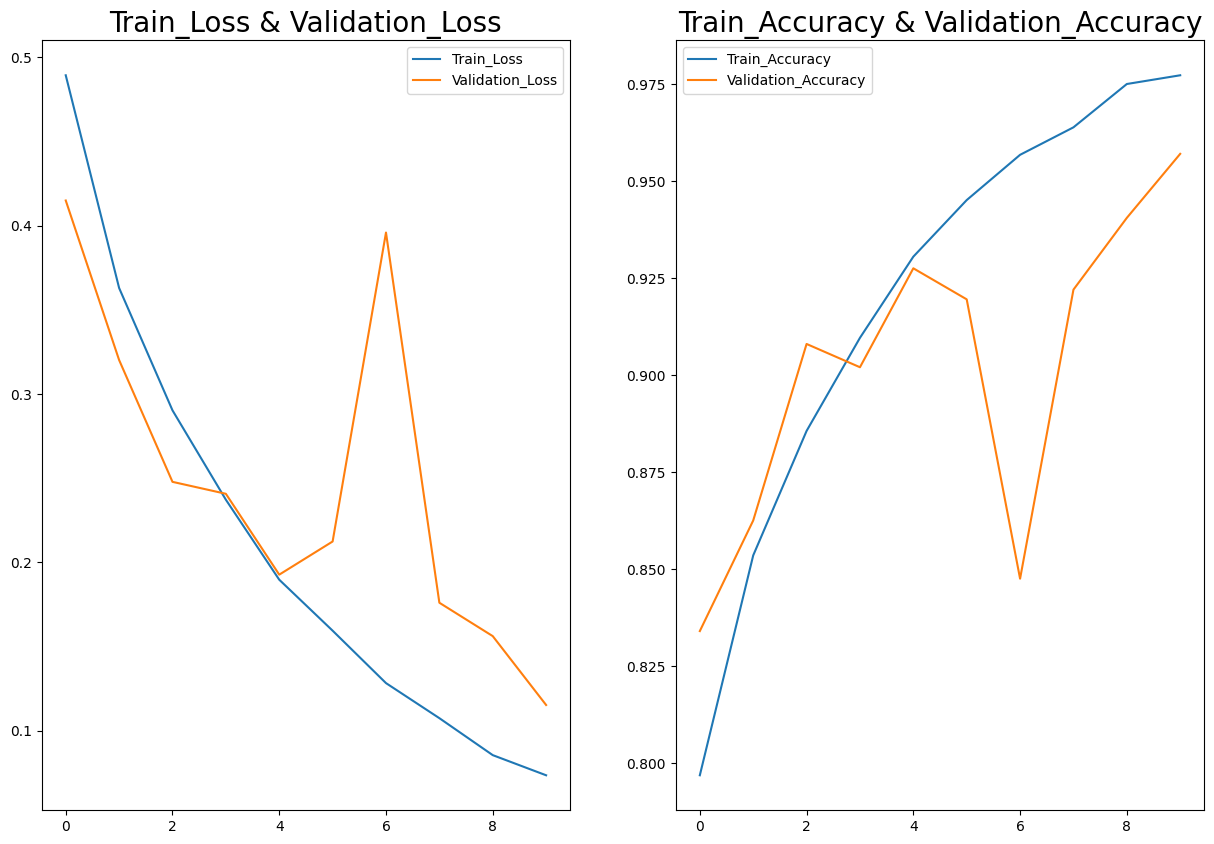

In [27]:
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.plot(hist_['loss'],label='Train_Loss')
plt.plot(hist_['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist_['accuracy'],label='Train_Accuracy')
plt.plot(hist_['val_accuracy'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()
plt.show()

In [28]:
y_test =test_generator.classes
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions,axis=1)
y_test = np.ravel(y_test)
y_pred = np.ravel(y_pred)
df = pd.DataFrame({'Actual': y_test, 'Prediction': y_pred})

63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 206ms/step


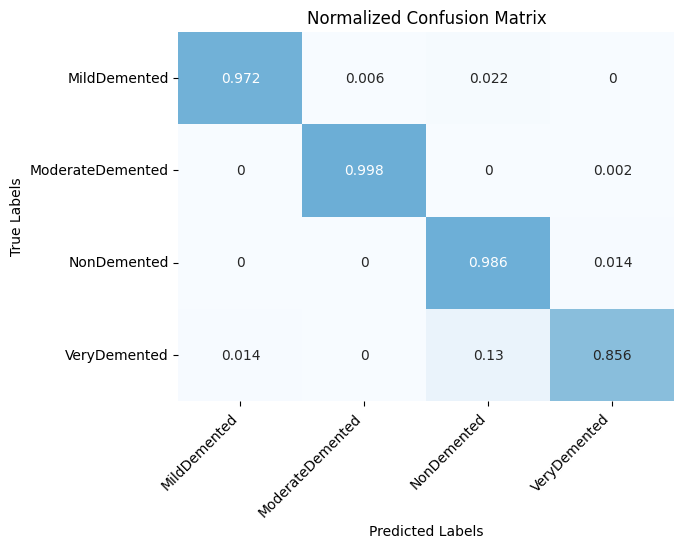

In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


CM = confusion_matrix(y_test, y_pred)


CM_percent = CM.astype('float') / CM.sum(axis=1)[:, np.newaxis]
class_names = ['MildDemented','ModerateDemented', 'NonDemented', 'VeryDemented']

sns.heatmap(CM_percent, fmt='g', center=True, cbar=False, annot=True,
            cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Normalized Confusion Matrix')
plt.show()


In [30]:
from sklearn.metrics import classification_report
class_names = ['MildDemented','ModerateDemented', 'NonDemented', 'VeryDemented']
ClassificationReport = classification_report(y_test, y_pred, target_names=class_names)
print('Classification Report is:\n', ClassificationReport)


Classification Report is:
                   precision    recall  f1-score   support

    MildDemented       0.99      0.97      0.98       500
ModerateDemented       0.99      1.00      1.00       500
     NonDemented       0.87      0.99      0.92       500
    VeryDemented       0.98      0.86      0.91       500

        accuracy                           0.95      2000
       macro avg       0.96      0.95      0.95      2000
    weighted avg       0.96      0.95      0.95      2000

